# HW 6
## Дедлайн: 13 декабря, 23:59

В этой домашке вам предстоит реализовать Wasserstain GAN и одну из её модификаций, а также разобраться с тем, как оценивать качество генеративных моделей

## Imports


In [ ]:
import argparse
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, clear_output
from tqdm.notebook import tqdm

manualSeed = 111

random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = torch.cuda.is_available()

In [ ]:
import os


def reset_seed(seed=manualSeed):
    torch.manual_seed(seed)
    np.random.seed(seed)


os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Data Loading: CIFAR

In [ ]:
!mkdir -p datasets

In [ ]:
BATCH_SIZE = 64
CIFAR_MEAN, CIFAR_STD = (0.5,), (0.5,)

cifar_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ]
)
cifar_train_dataset = datasets.CIFAR10(
    train=True,
    root="datasets/cifar_train/",
    transform=cifar_transforms,
    download=True
)
cifar_train_loader = DataLoader(
    cifar_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
cifar_val_dataset = datasets.CIFAR10(
    train=False,
    root="datasets/cifar_val/",
    transform=cifar_transforms,
    download=True
)
cifar_val_loader = DataLoader(
    cifar_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

100%|██████████| 170498071/170498071 [00:04<00:00, 41476440.82it/s]


Extracting datasets/cifar_train/cifar-10-python.tar.gz to datasets/cifar_train/


100%|██████████| 170498071/170498071 [00:04<00:00, 42246180.46it/s]


Extracting datasets/cifar_val/cifar-10-python.tar.gz to datasets/cifar_val/


### Plot data

In [ ]:
def denorm(img_tensors, mean, std):
    return img_tensors * std + mean


def show_images(images, mean, std, nmax=25):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(
        vutils.make_grid(
            denorm(
                images.detach()[:nmax],
                mean,
                std
            ),
            nrow=8
        ).permute(1, 2, 0)
    )


def show_batch(dl, mean, std, nmax=25):
    for images, _ in dl:
        show_images(images, mean, std, nmax)
        break

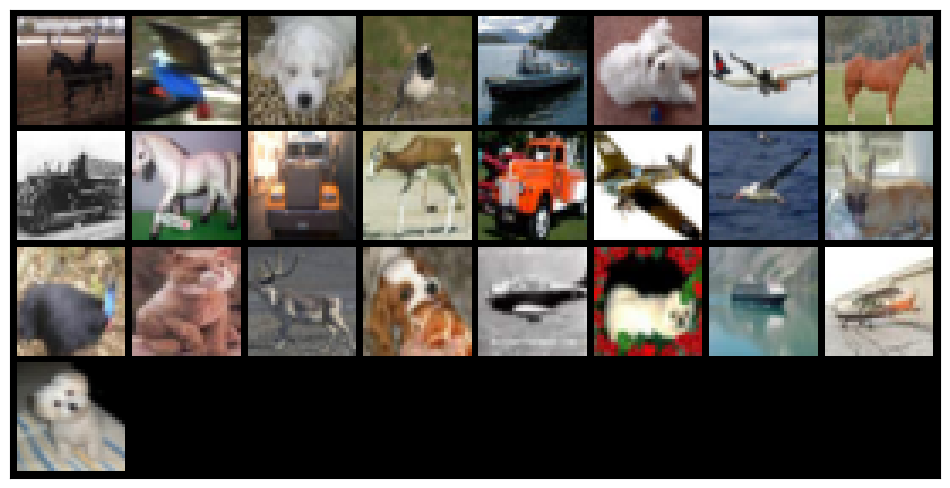

In [ ]:
show_batch(cifar_train_loader, torch.Tensor(CIFAR_MEAN), torch.Tensor(CIFAR_STD))

## WGAN-GP (5 pt)

In [ ]:
# do not change this function
def plot_losses(losses: np.ndarray, title: str):
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, losses)
    plt.title(title, fontsize=14)
    plt.xlabel("Iterations", fontsize=14)
    plt.ylabel("Loss", fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

### WGAN

[WGAN](https://arxiv.org/abs/1701.07875) model uses weight clipping to enforce Lipschitzness of the discriminator.

The model objective is
$$
\min_{G} W(\pi || p) \approx \min_{G} \max_{\boldsymbol{\phi} \in \boldsymbol{\Phi}} \left[ \mathbb{E}_{\pi(\mathbf{x})} f_{\boldsymbol{\phi}}(\mathbf{x})  - \mathbb{E}_{p(\mathbf{z})} f_{\boldsymbol{\phi}}(G_{\boldsymbol{\theta}}(\mathbf{z}))\right].
$$
Here $f_{\boldsymbol{\phi}}(\mathbf{x})$ is the discriminator model. The discriminator weights $\boldsymbol{\phi}$ should lie in the compact set $\boldsymbol{\Phi} = [-c, c]^d$.

In [ ]:
from typing import Optional


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_channels: int, clip_c: Optional[float] = None):
        super().__init__()
        self.n_channels = n_channels
        self.clip_c = clip_c
        # sequence of convolutional layers and LeakyRelU -> reshape -> FC
        # conv_sequence and fc are separated due to the simple feature extraction,
        #     which will be used in the second task, FID
        self.conv_sequence = nn.Sequential(
            nn.Conv2d(3,self.n_channels, kernel_size= 3 ,padding = 1) ,
            nn.BatchNorm2d(self.n_channels) ,
            nn.LeakyReLU() ,
            nn.Conv2d(self.n_channels ,16, kernel_size= 3 ,padding=1) ,
            nn.BatchNorm2d(16) ,
            nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features = 32*32*16, out_features =1 ) ,
            nn.Sigmoid()
        )


    def clip_weights(self) -> None:
        for layer in self.net:
            if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
                # clip the weight to the range [-clip_c, clip_c]
                # layer.weight.data = 'kek' # <CODE>
                layer.weight.data.clamp_(-self.clip_c, self.clip_c)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # input.shape = (n_samples, 3, 32, 32)
        # output.shape = (n_samples, 1)

        x = self.conv_sequence(input)
        # print(x.shape)
        x = x.reshape(x.shape[0] , 32*32*16 )

        out = self.fc(x)
        return out

    # Типо идея в том что это батчи с картинками но расслоенными на 16 каналов
    def get_features(self, input: torch.Tensor) -> torch.Tensor:
        # self.conv_sequence + flatten
        conv_features = self.conv_sequence(input)
        flat_features = conv_features.view(conv_features.size(0), -1)
        return flat_features

In [ ]:
diss = Discriminator(n_channels = 10)
x = torch.rand(12 , 3 , 32 , 32)
x = diss(x)
print(x)


# x = nn.Conv2d(3,10, kernel_size= 3 ,padding =1)(x) ; print(x.shape)
# x = nn.BatchNorm2d(10)(x) ; print(x.shape)
# x = nn.LeakyReLU()(x) ; print(x.shape)
# x = nn.Conv2d(10,16, kernel_size= 3 ,padding = 1)(x) ; print(x.shape)
# x = nn.BatchNorm2d(16)(x); print(x.shape)
# x = nn.LeakyReLU()(x); print(x.shape)

# x = x.reshape(x.shape[0] ,32*32*16 ) ; print(x.shape)

# x = nn.Linear(in_features = 32*32*16, out_features =1 )(x) ; print(x.shape)

tensor([[0.5348],
        [0.3903],
        [0.6366],
        [0.4570],
        [0.6318],
        [0.5032],
        [0.4810],
        [0.4215],
        [0.5233],
        [0.4262],
        [0.4608],
        [0.4387]], grad_fn=<SigmoidBackward0>)


In [ ]:
device = 'cuda'

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size: int = 128, n_channels: int = 64):
        super(Generator,self).__init__()

        self.input_size = input_size
        self.n_channels = n_channels

        # Define any NN architecture, which you prefer. For example:
        # 1) linear layer with output units 4 * 4 * 4 * n_channels, then relu
        # 2) transposed conv with stride 2, kernel size 2 then BN, then relu
        # 3) transposed conv with stride 2, kernel size 2 then BN, then relu
        # 4) transposed conv with stride 2, kernel size 2
        # self.net = nn.Sequential(
        #     nn.ConvTranspose1d(in_channels=1, out_channels=self.n_channels,kernel_size=2,stride=2) ,
        #     nn.BatchNorm1d(self.n_channels) ,
        #     nn.ReLU()
        # )

        layers = [    nn.Linear(input_size, 4 * 4 * 4 * n_channels),  # Linear layer
                    nn.ReLU(inplace=True),
                    nn.Unflatten(1, (4 * n_channels, 4, 4)),  # Reshape to (batch_size, 4 * n_channels, 4, 4)
                    ]

        tmp = 4 * n_channels
        for j in range(3) :
            layers += [ nn.ConvTranspose2d(tmp, tmp//2, kernel_size=2, stride=2, padding=0) ,
            nn.BatchNorm2d(tmp//2) ,
            nn.ReLU(inplace=True) ]
            tmp = tmp//2
            assert tmp > 0
            # print(nn.Sequential(*layers)(x).shape)
            # print(layers)
        layers += [nn.ConvTranspose2d(tmp, 3, kernel_size=1, stride=1, padding=0),  # Transposed Conv3
            nn.Tanh()  # Output in the range [-1, 1] for better training stability
              ]
        self.net = nn.Sequential(*layers)



    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # input.shape = (n_samples, self.input_size)
        # out.shape = (n_samples, 3, 32, 32)
        # x = input.unsqueeze(1)
        out = self.net(x)
        return out

    def sample(self, n_samples: int) -> torch.Tensor:
        # Generate random samples with shape (n_samples, self.input_size)
        # Apply forward pass to the array from the previous step
        # noise = # <CODE>
        # noisy_samples = # <CODE>
        # return noisy_samples
        # print('gen test')
        noise = torch.randn(n_samples, self.input_size).to(device)
        # print(noise.shape)
        generated_samples = self.net(noise) # А почему нельзя self.forward >>> ?????????????????????????????
        # print('complete')
        return generated_samples



In [ ]:
gen = Generator(input_size = 128 , n_channels = 128  ).to(device)
x = torch.randn(10,128).to(device)
x = gen.forward(x)
print(x.shape)

x = gen.sample(12)
print(x.shape)

torch.Size([10, 3, 32, 32])
torch.Size([12, 3, 32, 32])


In [ ]:
for j in range(1,12) :
    x = torch.randn(j,128)
    x = gen.forward(x) ; print( x.shape )

torch.Size([1, 3, 32, 32])
torch.Size([2, 3, 32, 32])
torch.Size([3, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([5, 3, 32, 32])
torch.Size([6, 3, 32, 32])
torch.Size([7, 3, 32, 32])
torch.Size([8, 3, 32, 32])
torch.Size([9, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([11, 3, 32, 32])


In [ ]:
n_channels = 256 ; input_size = 256
x = torch.randn(12 , input_size)


layers = [    nn.Linear(input_size, 4 * 4 * 4 * n_channels),  # Linear layer
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (4 * n_channels, 4, 4)),  # Reshape to (batch_size, 4 * n_channels, 4, 4)
            ]
print(nn.Sequential(*layers)(x).shape)

tmp = 4*n_channels
for j in range(3) :
    print(tmp)
    layers += [ nn.ConvTranspose2d(tmp, tmp//2, kernel_size=2, stride=2, padding=0) ,
    nn.BatchNorm2d(tmp//2) ,
    nn.ReLU(inplace=True) ]
    tmp = tmp//2
    assert tmp > 0
    print(nn.Sequential(*layers)(x).shape)
    # print(layers)
layers += [nn.ConvTranspose2d(tmp, 3, kernel_size=1, stride=1, padding=0),  # Transposed Conv3
    nn.Tanh()  # Output in the range [-1, 1] for better training stability
      ]
print(nn.Sequential(*layers)(x).shape)

# x = nn.Linear(256, 4 * 4 * 4 * n_channels)(x) ; print(x.shape)
# x = nn.ReLU(inplace=True)(x) ; print(x.shape)
# x = nn.Unflatten(1, (4 * n_channels, 4, 4))(x) ; print(x.shape)


# tmp = int(4 * n_channels)
# for j in range(N_convs) :
#     print(tmp)
#     x = nn.ConvTranspose2d(int(tmp), int(tmp/2), kernel_size=2, stride=2, padding=0)(x) ; print(x.shape)
#     x = nn.BatchNorm2d(int(tmp/2))(x) ; print(x.shape)
#     x = nn.ReLU(inplace=True)(x) ; print(x.shape)
#     tmp = tmp/2
#     assert tmp > 0
# x = nn.ConvTranspose2d( 16, 3, kernel_size=1, stride=1, padding=0)(x) ; print(x.shape)
# x = nn.Tanh()(x) ; print(x.shape)

torch.Size([12, 1024, 4, 4])
1024
torch.Size([12, 512, 8, 8])
512
torch.Size([12, 256, 16, 16])
256
torch.Size([12, 128, 32, 32])
torch.Size([12, 3, 32, 32])


### Gradient Penalty

[WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf)  model uses gradient penalty to enforce Lipschitzness.

The model objective is
$$
    W(\pi || p) = \underbrace{\mathbb{E}_{\pi(\mathbf{x})} f_{\boldsymbol{\phi}}(\mathbf{x})  - \mathbb{E}_{p(\mathbf{x} | \boldsymbol{\theta})} f_{\boldsymbol{\phi}}(\mathbf{x})}_{\text{original critic loss}} + \lambda \underbrace{\mathbb{E}_{U[0, 1]} \left[ \left( \| \nabla_{\hat{\mathbf{x}}} f_{\boldsymbol{\phi}}(\hat{\mathbf{x}}) \|_2 - 1 \right) ^ 2\right]}_{\text{gradient penalty}},
$$
where the samples $\hat{\mathbf{x}}_\alpha = \alpha \mathbf{x} + (1 - \alpha) \mathbf{y}$ with $\alpha \in [0, 1]$ are uniformly sampled along straight lines between pairs of points: $\mathbf{x}$ from the data distribution $\pi(\mathbf{x})$ and $\mathbf{y}$ from the generator distribution $p(\mathbf{x} | \boldsymbol{\theta}))$.

In [ ]:
def calculate_gradient_penalty(model, real_images, fake_images, device):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Calculate interpolation x_\alpha = \alpha * x_real + (1 - \alpha) x_fake
    # 1) sample \alpha
    # 2) create x_\alpha (be careful about shapes and requires_grad)
    # 3) apply discriminator to x_\alpha

    # alpha = # <CODE>
    alpha = torch.rand(real_images.size(0), 1, 1, 1).to(device)
    # interpolates = # <CODE>
    interpolates = alpha * real_images + (1 - alpha) * fake_images
    interpolates.requires_grad_(True) # ?????
    # model_interpolates = # <CODE>
    model_interpolates = model(interpolates)
    grad_outputs = torch.ones(model_interpolates.size(), device=device, requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=model_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    # gradient_penalty = # <CODE>
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


def test_gradient_penalty():
    x = np.random.normal(size=(10, 4))
    x_norm = np.mean(np.sqrt(x**2))
    x = torch.randn(size=(10, 4))
    x.requires_grad = True
    assert gradient_penalty(lambda x: x, x, x).numpy() == 1
    assert gradient_penalty(lambda x: x * 0, x, x).numpy() == 1


# test_gradient_penalty()

The training loop

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
def train_wgan(
    generator: object,
    discriminator: object,
    train_loader: object,
    disc_steps: int,
    batch_size: int,
    n_epochs: int,
    lr: float,
    use_cuda: bool = False,
    gp_weight: Optional[float] = None,
) -> dict:

    if use_cuda:
        discriminator = discriminator.cuda()
        generator = generator.cuda()

    discriminator.train()
    generator.train()

    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0, 0.9))

    curr_iter = 0
    d_loss, g_loss = torch.zeros(1), torch.zeros(1)
    batch_loss_history = {"discriminator_losses": [], "generator_losses": []}

    for epoch_i in tqdm(range(n_epochs)):
        for batch_i, x in enumerate(train_loader):
            curr_iter += 1
            # print('ITER')
            if use_cuda:
                x = x[0].cuda()
            # print('wtf')

            # Update discriminator weights
            # D(x_fake) - D(x_real)
            disc_optimizer.zero_grad()
            # fake_data = # <CODE>
            # fake_data = generator.sample(batch_size).detach() WTF why detach
            # print('kek')

            fake_data = generator.sample(torch.tensor(batch_size)).to(device)


            # <CODE>

            # print('FAKE DATA : ' ,fake_data.shape)
            disc_fake = discriminator(fake_data)
            # print('DISK FAKE : ',disc_fake.shape)

            # print('X SHAPE: ',x[0].shape)
            disc_real = discriminator(x)
            # print('DISK REAL: ' , disc_real.shape)
            d_loss = disc_fake.mean() - disc_real.mean()
            # print('kek')

            if gp_weight is not None:
                gp = calculate_gradient_penalty(discriminator, x, fake_data,device=device)
                d_loss += gp_weight * gp

            d_loss.backward()
            disc_optimizer.step()

            # generator update
            if curr_iter % disc_steps == 0:
                gen_optimizer.zero_grad()
                fake_data = generator.sample(batch_size)
                # -D(x_fake)
                # <CODE>
                g_loss = -discriminator(fake_data).mean()

                g_loss.backward()
                gen_optimizer.step()

                batch_loss_history["generator_losses"].append(g_loss.data.cpu().numpy())
                batch_loss_history["discriminator_losses"].append(
                    d_loss.data.cpu().numpy()
                )

    return batch_loss_history

  0%|          | 0/20 [00:00<?, ?it/s]

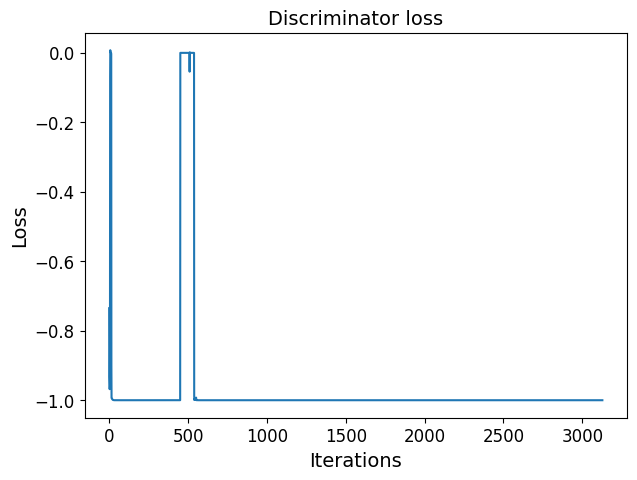

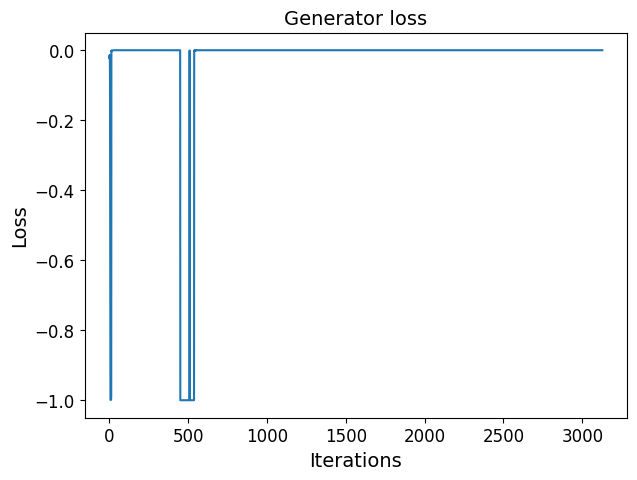

In [ ]:
# choose these parameters (you have to train the model more than 20 epochs to get good results)
N_CHANNELS = 64     # > 32
N_EPOCHS =  20     # > 10
DISC_STEPS =  5 # > 2
CLIP_C = 0.8        # < 1
LR =   3e-4          # < 1e-3
# ====

generator = Generator(n_channels=N_CHANNELS)
discriminator = Discriminator(n_channels=N_CHANNELS, clip_c=CLIP_C)

train_losses = train_wgan(
    generator,
    discriminator,
    cifar_train_loader,
    disc_steps=DISC_STEPS,
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS,
    lr=LR,
    use_cuda=USE_CUDA,
)

plot_losses(train_losses["discriminator_losses"], "Discriminator loss")
plot_losses(train_losses["generator_losses"], "Generator loss")

Не забудьте сохранить обученную модель! Она пригодится в следующем пункте

In [ ]:
torch.save(generator.state_dict(), '<GEN_PATH>')
torch.save(discriminator.state_dict(), '<DISC_PATH>')

## Метрики качества (5 pt)

Здесь вам предстоит оценить качество изображений, сгенерированных обученным ранее ГАНом.

In [ ]:
generator = Generator(n_channels=N_CHANNELS)
discriminator = Discriminator(n_channels=N_CHANNELS, clip_c=CLIP_C)

generator.load_state_dict(torch.load('<GEN_PATH>'))
generator.eval()

discriminator.load_state_dict(torch.load('<DISC_PATH>'))
discriminator.eval()

Discriminator(
  (conv_sequence): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (fc): Sequential(
    (0): Linear(in_features=16384, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [ ]:
generator.to(device)

Generator(
  (net): Sequential(
    (0): Linear(in_features=128, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Unflatten(dim=1, unflattened_size=(256, 4, 4))
    (3): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
    (13): Tanh()
  )
)

In [ ]:
real_data = generator.sample(10).detach()

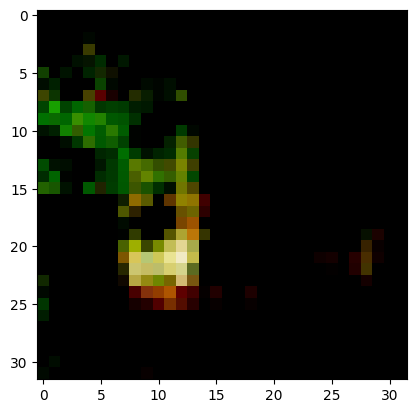

In [ ]:
for j in real_data :
    plt.imshow(j.permute(1,2,0).cpu())

In [ ]:
def show_sample(model , n , mean , std) :
    images = model.sample(n).detach().cpu()
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(
        vutils.make_grid(
            denorm(
                images,
                mean,
                std
            ),
            nrow=8
        ).permute(1, 2, 0)
    )


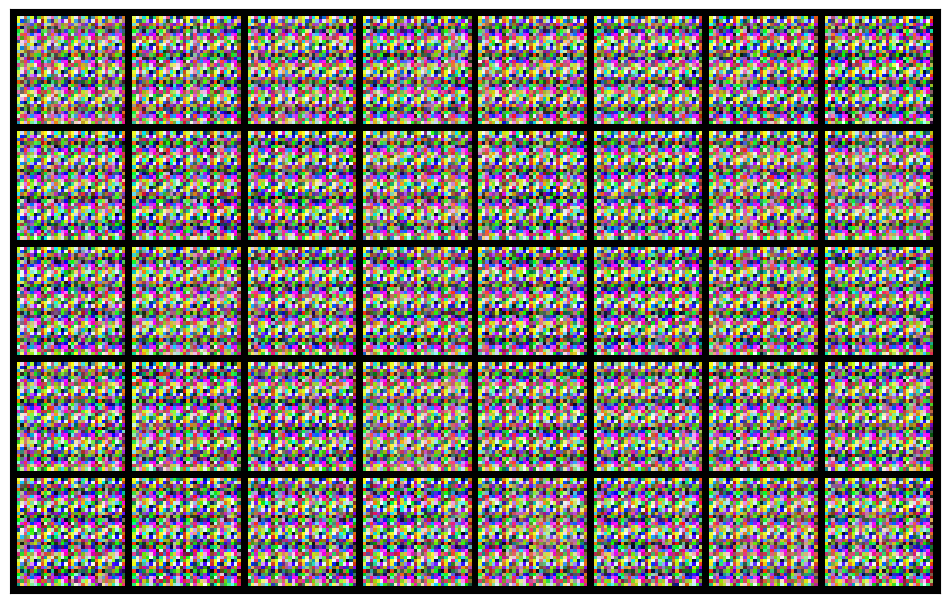

In [ ]:
show_sample(generator , 40 ,  torch.Tensor(CIFAR_MEAN), torch.Tensor(CIFAR_STD) )

In [ ]:
discriminator(generator.sample(40).detach().cpu())

tensor([[   590.7813],
        [ -8712.8984],
        [ -2512.2517],
        [ -5872.0278],
        [ -2350.6145],
        [  1624.6509],
        [  1665.7935],
        [ -7767.1123],
        [ -7012.6445],
        [ -6650.5059],
        [  -424.9505],
        [ -6058.4199],
        [   887.7154],
        [ -8841.1396],
        [ -3573.4500],
        [ -9722.1094],
        [  1858.1354],
        [ -8177.3711],
        [ -9103.1621],
        [ -9930.1445],
        [-10494.3398],
        [ -5155.4004],
        [ -1191.0701],
        [ -1068.2642],
        [ -3199.0168],
        [ -5269.0015],
        [   131.5901],
        [  -750.6679],
        [  -593.0941],
        [ -5090.7744],
        [  -288.4568],
        [ -5620.7061],
        [   933.9123],
        [  -466.4999],
        [ -4230.8750],
        [  -242.5551],
        [ -9908.2148],
        [ -2013.1057],
        [ -2107.2578],
        [ -5477.6021]], grad_fn=<AddmmBackward0>)

### 1. Визуализация распределений (1 pt)

Воспользуйтесь методом, снижающим размерность (TSNE, UMAP, PCA, ...) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи.

Дайте комментарий получившимся результатам

In [ ]:
# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA
# !pip install umap-learn + from umap import UMAP
# <CODE>

### 2. Leave-One-Out 1NN Classifier (2 pt)

Идея подхода такова:
- сгенерировать $n$ фейковых изображений, взять $n$ настоящих из обучающей выборке; присвоить фейковым изображениям класс 0, настоящим – класс 1.
- обучить 1NN Classifier предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет sklearn.model_selection.LeaveOneOut


Каково идеальное значение метрики?
Каким вышел результат вашей модели?

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# <CODE>

### 3. Frechet Inception Distance (FID) (2 pt)

$$
	\text{FID} (\pi, p) = \| \mathbf{m}_{\pi} - \mathbf{m}_{p}\|_2^2 + \text{Tr} \left( \boldsymbol{\Sigma}_{\pi} + \boldsymbol{\Sigma}_p - 2 \sqrt{\boldsymbol{\Sigma}_{\pi} \boldsymbol{\Sigma}_p} \right)
$$

* $\mathbf{m}_{\pi}$, $\boldsymbol{\Sigma}_{\pi} $ вектор среднего и ковариационная матрица признакового представления сэмплов из $\pi(\mathbf{x})$
* $\mathbf{m}_{p}$, $\boldsymbol{\Sigma}_p$ вектор среднего и ковариационная матрица признакового представления сэмплов из  $p(\mathbf{x} | \boldsymbol{\theta})$.

Для начала реализуем функцию подсчёта расстояния Фреше

In [ ]:
# Helper function
def get_matrix_sqrt(x: torch.Tensor) -> torch.Tensor:
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    if not np.isfinite(y).all():
        print("bad!")
    return torch.Tensor(y.real, device=x.device)

In [ ]:
def get_distance(
    mu_x: torch.Tensor, mu_y: torch.Tensor, sigma_x: torch.Tensor, sigma_y: torch.Tensor
) -> torch.Tensor:
    # <CODE>


def test_get_distance():
    mu_x = torch.ones(3)
    mu_y = torch.ones(3) * 10
    sigma_x = torch.eye(3) * 5
    sigma_y = torch.eye(3) * 3
    dist = get_distance(mu_x, mu_y, sigma_x, sigma_y)
    assert np.isclose(dist, 243.7621)


test_get_distance()

Далее реализуем функцию вычисления промежуточных представлений настоящих и сгенерированных изображений

Для генерации признаков воспользуйтесь методом `get_features` из класса `Discriminator`

In [ ]:
def get_features(
    generator: object,
    discriminator: object,
    loader: object,
    n_samples: int,
    batch_size: int,
) -> tuple:
    if USE_CUDA:
        generator = generator.cuda()
        discriminator.cuda()

    generator.eval()
    discriminator.eval()

    fake_features_list = []
    real_features_list = []
    cur_samples = 0

    with torch.no_grad():
        for real_samples in loader:
            if USE_CUDA:
                real_samples = real_samples.cuda()
            # get features of real samples
            # <CODE>
            real_features_list.append(real_features)

            fake_samples = generator.sample(len(real_samples), step=3)
            if USE_CUDA:
                fake_samples = fake_samples.cuda()

            # get features of fake samples
            # <CODE>
            fake_features_list.append(fake_features)

            cur_samples += len(real_samples)
            if cur_samples >= n_samples:
                break

    fake_features_all = torch.cat(fake_features_list)
    real_features_all = torch.cat(real_features_list)
    return fake_features_all, real_features_all

Теперь вы готовы реализовать основную функцию подсчёта FID

In [ ]:
def get_frechet_inception_distance(
    generator: object,
    discriminator: object,
    loader: object,
    n_samples: int,
    batch_size: int,
) -> torch.Tensor:
    # 1) get features
    # 2) calculate stats
    # 3) get distance
    # <CODE>

А теперь посчитайте FID на валидационном датасете

In [ ]:
N_SAMPLES = 10000

reset_seed()

fid = get_frechet_inception_distance(
    generator,
    discriminator,
    loader=cifar_val_loader,
    n_samples=N_SAMPLES,
    batch_size=BATCH_SIZE,
)
print(fid)